<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/30_mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###univariate time series LSTM first try

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print(tf.__version__)

2.5.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

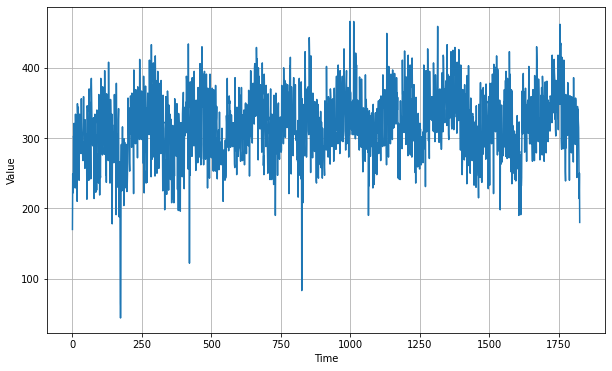

In [57]:
#df = pd.read_csv('reffined_data.csv')
df = pd.read_csv('data_pca_dt_covid_fi.csv')
df = df.iloc[:1826]

series = np.array(df['flux_journalier'])
#time_step = np.array(df['Date'])
time = np.array([i for i in range(len(df))]) 
plt.figure(figsize=(10, 6))
plot_series(time, series)

Clean data by removing the three pics from the series

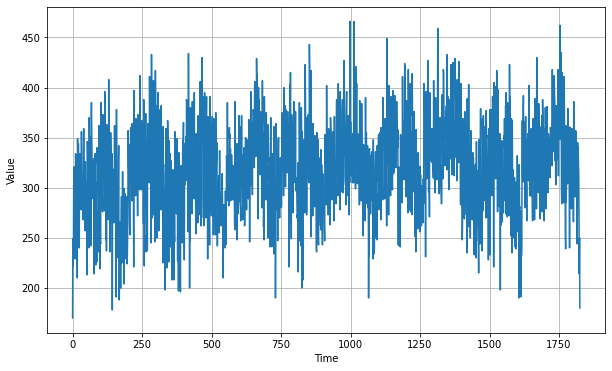

In [58]:
denoised_series = [i if i>150 else 200 for i in list(series)]

plt.figure(figsize=(10, 6))
plot_series(time, denoised_series)

In [59]:
denoised_series = np.array(denoised_series)

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(denoised_series.reshape(-1,1))
series = scaler.transform(denoised_series.reshape(-1,1))

split_time = 1250  #600
time_train = time[:split_time]
x_train = series[:split_time] 
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 7 # 30 slices worth of data, so we're splitting the x_train 30 times !!!

#x_train = np.concatenate((x_train-1, x_train, x_train+1))

print('total',series.shape)
print('train',x_train.shape)
print('test', x_valid.shape)



total (1826, 1)
train (1250, 1)
test (576, 1)


In [79]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [80]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

In [81]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 32 #128
shuffle_buffer = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  #tf.keras.layers.MaxPool1D(pool_size=2),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(512, return_sequences=True),
  #tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.Dense(90, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

# The whole purpose of this cell is to know which learning rate to use using the lr_schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.95)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])


train_set=  <PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (1250, 1)
Epoch 1/20
39/39 [==============================] - 3s 14ms/step - loss: 0.2517 - mae: 0.5556
Epoch 2/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0448 - mae: 0.2302
Epoch 3/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0281 - mae: 0.1836
Epoch 4/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0223 - mae: 0.1645
Epoch 5/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0184 - mae: 0.1493
Epoch 6/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0166 - mae: 0.1422
Epoch 7/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0150 - mae: 0.1347
Epoch 8/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0140 - mae: 0.1314
Epoch 9/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0130 - mae: 0.1265
Epoch 10/20
39

In [82]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print("1",scaler.inverse_transform(rnn_forecast.reshape(-1,1)))
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0] 
print("\n2",np.array(rnn_forecast.shape))

1 [[289.57758]
 [269.86523]
 [250.5634 ]
 ...
 [303.5223 ]
 [306.7461 ]
 [300.23477]]
(1820, 7, 1)

2 [576]


In [83]:
#results['Date'] = df['Date']
pred = pd.DataFrame(scaler.inverse_transform(rnn_forecast.reshape(-1,1)))
real = pd.DataFrame(scaler.inverse_transform(x_valid))

results = pd.concat([real,pred, real-pred], axis = 1)
#results = results.rename(columns={0: ('flux_réel', 'prediction')})
print('Max = ', max(results.iloc[:,2]))
print([int(i) for i in list(results.iloc[:,2])])

Max =  125.2259521484375
[17, -10, 4, -13, 2, -21, -12, 12, 2, -14, -11, -21, 23, -4, 108, 69, 47, 63, 19, 23, -87, 14, 36, -31, -29, 3, 23, 17, 53, 0, 5, -32, -5, 3, -45, 13, -29, -21, 58, -14, 31, 36, -59, 8, -10, -6, 13, -14, -11, 79, 14, -38, -20, 39, -12, 6, 3, 1, -12, 3, 14, 2, -14, 3, 106, 11, 0, 13, 15, -23, -60, -43, 21, -61, -38, -20, -9, -15, -56, -11, 92, 0, -1, 20, 125, 104, 16, -38, 5, 14, -4, -12, -41, -1, 25, 36, 24, -8, 87, -27, 14, 17, 3, -18, -50, 15, 37, -26, -49, 12, 40, 10, 49, 5, -32, -18, 20, 37, 3, 27, -32, 24, -5, 13, 40, -31, 41, 48, 31, 78, 18, -7, 18, -99, 46, 26, -41, -27, 2, 11, 98, -58, 7, 32, 8, 4, -62, 38, 32, -91, -51, -52, -58, -22, 7, 35, 20, 17, 53, -25, -21, 27, -18, 3, 22, 28, 8, -18, 12, -72, 75, -21, 2, 0, -49, 97, 38, -25, 31, -29, 14, -37, -45, 46, 1, 11, -14, 20, -25, 22, 1, -31, 20, -33, -13, -57, 17, -32, -9, 16, 33, -15, -54, 60, 7, -17, 26, -24, -18, -41, -55, -72, 63, 23, -3, -28, -44, 63, 82, -42, -1, -16, -47, -57, -43, 66, 25, -39, 8

In [84]:
mae = tf.keras.metrics.mean_absolute_error(np.squeeze(scaler.inverse_transform(x_valid)), 
                                     np.squeeze(scaler.inverse_transform(rnn_forecast.reshape(-1,1)))).numpy()

Mean Absolute Error =  30.497192


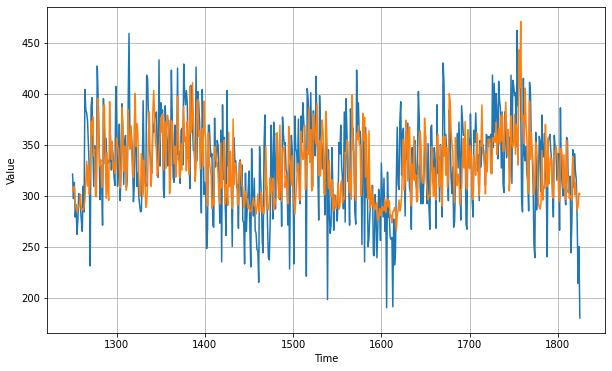

In [85]:
#print(time_valid.shape)      
#print(x_valid.shape)         
#print(rnn_forecast.shape)    
plt.figure(figsize=(10, 6))
title = str("Forecasting with LSTM")
plot_series(time_valid, scaler.inverse_transform(x_valid)) # 2-D
plot_series(time_valid, scaler.inverse_transform(rnn_forecast.reshape(-1,1))) # we only took the last part of the rnn_forecast
print('Mean Absolute Error = ', mae)

In [76]:
tf.keras.metrics.mean_absolute_error(np.squeeze(x_valid), 
                                                np.squeeze(rnn_forecast)).numpy()

0.10331478

In [77]:
tf.keras.metrics.mean_absolute_percentage_error(np.squeeze(x_valid), 
                                                np.squeeze(rnn_forecast)).numpy()

27.014711